In [14]:
##Assam_LST_missing_values

Total pixels inside Assam: 87975
2020 June → LST missing: 29917/87975 (34.01%)
2020 June → Raw Precip missing: 921/87975 (1.05%)
2020 July → LST missing: 72039/87975 (81.89%)
2020 July → Raw Precip missing: 921/87975 (1.05%)
2020 August → LST missing: 15774/87975 (17.93%)
2020 August → Raw Precip missing: 921/87975 (1.05%)
2020 September → LST missing: 3710/87975 (4.22%)
2020 September → Raw Precip missing: 921/87975 (1.05%)
2021 June → LST missing: 40144/87975 (45.63%)
2021 June → Raw Precip missing: 921/87975 (1.05%)
2021 July → LST missing: 30503/87975 (34.67%)
2021 July → Raw Precip missing: 921/87975 (1.05%)
2021 August → LST missing: 39611/87975 (45.03%)
2021 August → Raw Precip missing: 921/87975 (1.05%)
2021 September → LST missing: 921/87975 (1.05%)
2021 September → Raw Precip missing: 921/87975 (1.05%)
2022 June → LST missing: 71311/87975 (81.06%)
2022 June → Raw Precip missing: 921/87975 (1.05%)
2022 July → LST missing: 7212/87975 (8.20%)
2022 July → Raw Precip missing: 921/

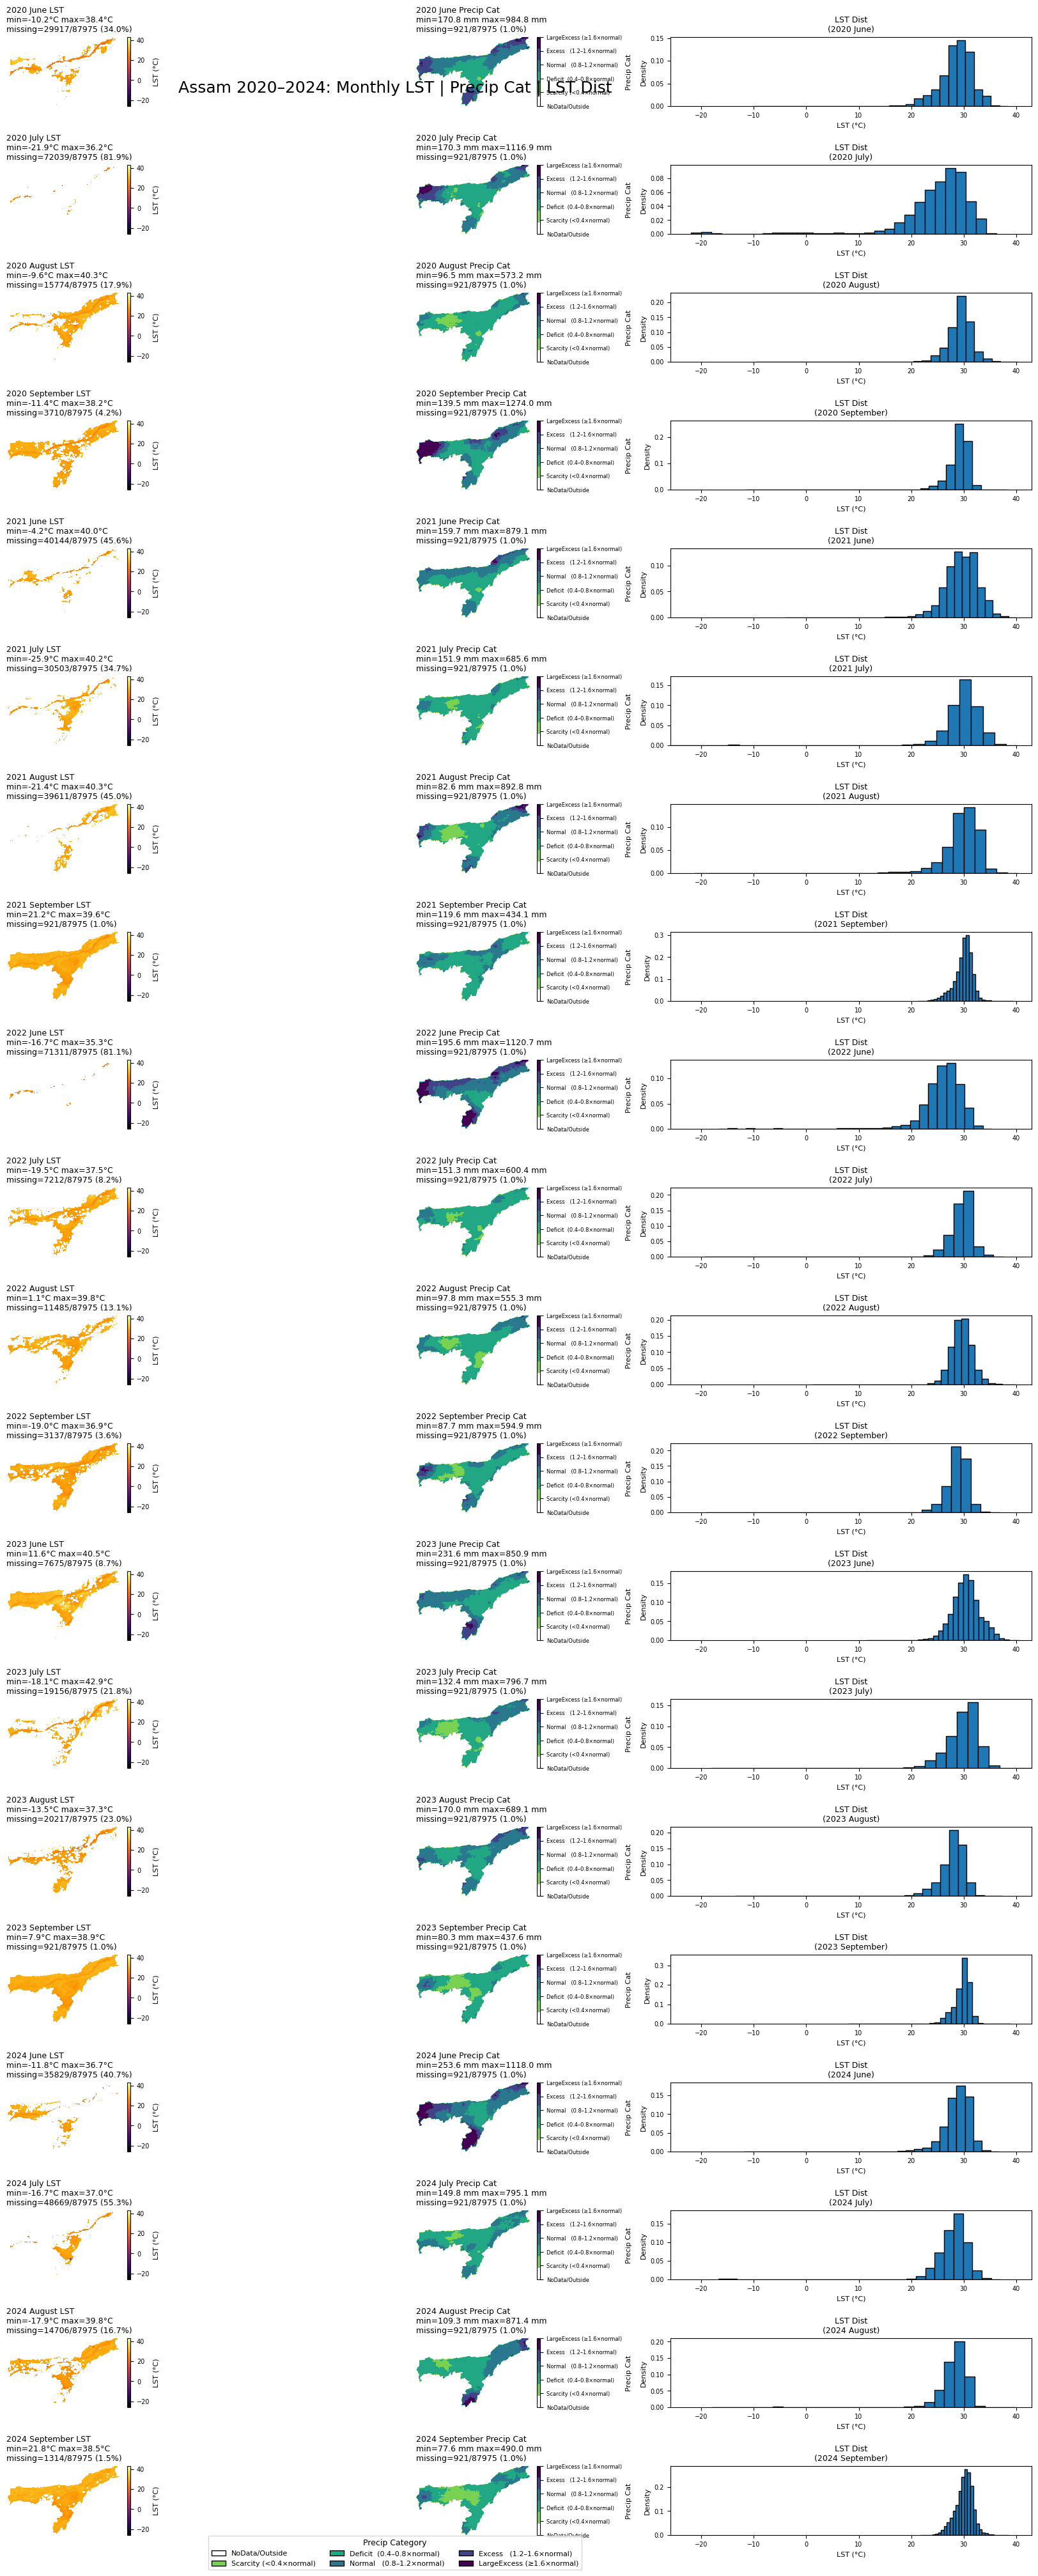

In [1]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Assam)
# -----------------------------------------------------------------------------
lst_tiff_path        = "Assam_X_LST.tif"                      # 20 bands (2020–2024 × 4: Jun–Sep)
precip_raw_tiff_path = "Assam_Y_Precipitation_CHIRPS.tif"     # 25 bands (2020–2024 × 5)
precip_cat_tiff_path = "Assam_Y_Precipitation_GT_geotif.tif"  # 25 bands (2020–2024 × 5)
india_shapefile      = "SateMask/gadm41_IND_1.shp"            # contains all Indian states

for p in (lst_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) LOAD INDIA STATES & BUILD ASSAM MASK
# -----------------------------------------------------------------------------
gdf = gpd.read_file(india_shapefile)
gdf_assam = gdf[gdf["NAME_1"].str.lower() == "assam"]
if gdf_assam.empty:
    raise ValueError("No 'Assam' feature found in shapefile.")

# read LST to get georeference
with rasterio.open(lst_tiff_path) as src:
    transform = src.transform
    crs       = src.crs
    height    = src.height
    width     = src.width

if gdf_assam.crs != crs:
    gdf_assam = gdf_assam.to_crs(crs)

assam_geom = [gdf_assam.geometry.union_all()]
assam_mask = geometry_mask(
    assam_geom,
    transform=transform,
    invert=True,
    out_shape=(height, width)
)

total_inside = np.count_nonzero(assam_mask)
print(f"Total pixels inside Assam: {total_inside}")

# -----------------------------------------------------------------------------
# 3) READ & MASK LST
# -----------------------------------------------------------------------------
with rasterio.open(lst_tiff_path) as src:
    lst_bands = src.read().astype(np.float32)  # (20, H, W)

if lst_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {lst_tiff_path}, found {lst_bands.shape[0]}")

for i in range(lst_bands.shape[0]):
    b = lst_bands[i]
    b[~assam_mask] = np.nan
    lst_bands[i] = b

# -----------------------------------------------------------------------------
# 4) READ & MASK RAW PRECIPITATION
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src:
    pr_raw_full = src.read().astype(np.float32)  # (25, H, W)

if pr_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in raw precip, found {pr_raw_full.shape[0]}")

for i in range(pr_raw_full.shape[0]):
    arr = pr_raw_full[i]
    arr[~assam_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 5) READ & MASK PRECIPITATION CATEGORY
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src:
    pr_cat_full = src.read().astype(np.int8)  # (25, H, W)

if pr_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in precip cat, found {pr_cat_full.shape[0]}")

for i in range(pr_cat_full.shape[0]):
    arr = pr_cat_full[i]
    arr[~assam_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 6) EXTRACT 20 MONTHLY BANDS (drop each year's “Total”)
# -----------------------------------------------------------------------------
monthly_idxs = []
for y in range(5):
    base = y * 5
    monthly_idxs += [base + m for m in range(4)]

precip_raw_bands = pr_raw_full[monthly_idxs]  # (20,H,W)
precip_cat_bands = pr_cat_full[monthly_idxs]  # (20,H,W)

# -----------------------------------------------------------------------------
# 7) SETUP YEARS, MONTHS & COLORMAPS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
months      = ["June", "July", "August", "September"]
n_years, n_months = len(years), len(months)
n_total     = n_years * n_months  # 20

# overall LST range
all_lst = lst_bands.flatten()
all_lst = all_lst[~np.isnan(all_lst)]
lst_vmin = float(np.nanmin(all_lst)) if all_lst.size else 0.0
lst_vmax = float(np.nanmax(all_lst)) if all_lst.size else 50.0
lst_cmap = plt.get_cmap("inferno")

# precip category palette
cluster_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
cluster_cmap    = ListedColormap(cluster_colors)
cluster_labels  = {
    0: "NoData/Outside",
    1: "Scarcity (<0.4×normal)",
    2: "Deficit  (0.4–0.8×normal)",
    3: "Normal   (0.8–1.2×normal)",
    4: "Excess   (1.2–1.6×normal)",
    5: "LargeExcess (≥1.6×normal)"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(6)
]

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(n_total, 3, figsize=(20, n_total*2.0), constrained_layout=True)
fig.suptitle("Assam 2020–2024: Monthly LST | Precip Cat | LST Dist", fontsize=18, y=0.97)
if n_total == 1:
    axes = axes[np.newaxis, :]

# -----------------------------------------------------------------------------
# 9) LOOP MONTHS, PRINT & PLOT
# -----------------------------------------------------------------------------
for i in range(n_total):
    yidx, midx = divmod(i, n_months)
    year, mon = years[yidx], months[midx]

    # LST stats + missing
    lst_layer = lst_bands[i]
    valid_lst = lst_layer[~np.isnan(lst_layer)]
    lst_min = float(np.nanmin(valid_lst)) if valid_lst.size else np.nan
    lst_max = float(np.nanmax(valid_lst)) if valid_lst.size else np.nan
    miss_lst = np.count_nonzero(np.isnan(lst_layer[assam_mask]))
    pct_lst  = miss_lst / total_inside * 100
    print(f"{year} {mon} → LST missing: {miss_lst}/{total_inside} ({pct_lst:.2f}%)")

    # Precip stats + missing
    pr_layer = precip_raw_bands[i]
    valid_pr = pr_layer[~np.isnan(pr_layer)]
    pr_min = float(np.nanmin(valid_pr)) if valid_pr.size else np.nan
    pr_max = float(np.nanmax(valid_pr)) if valid_pr.size else np.nan
    miss_pr = np.count_nonzero(np.isnan(pr_layer[assam_mask]))
    pct_pr  = miss_pr / total_inside * 100
    print(f"{year} {mon} → Raw Precip missing: {miss_pr}/{total_inside} ({pct_pr:.2f}%)")

    # category map
    raw_cat = precip_cat_bands[i]
    cat_plot = np.zeros_like(raw_cat, dtype=np.int8)
    ok = (raw_cat != -1)
    cat_plot[ok] = raw_cat[ok] + 1

    # — Column 0: LST Map —
    ax0 = axes[i,0]
    im0 = ax0.imshow(lst_layer, cmap=lst_cmap, vmin=lst_vmin, vmax=lst_vmax)
    title0 = (
        f"{year} {mon} LST\n"
        f"min={lst_min:.1f}°C max={lst_max:.1f}°C\n"
        f"missing={miss_lst}/{total_inside} ({pct_lst:.1f}%)"
    )
    ax0.set_title(title0, loc="left", fontsize=9)
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, fraction=0.04, pad=0.02)
    c0.set_label("LST (°C)", fontsize=8); c0.ax.tick_params(labelsize=7)

    # — Column 1: Precip Cat Map —
    ax1 = axes[i,1]
    im1 = ax1.imshow(cat_plot, cmap=cluster_cmap, vmin=0, vmax=5)
    title1 = (
        f"{year} {mon} Precip Cat\n"
        f"min={pr_min:.1f} mm max={pr_max:.1f} mm\n"
        f"missing={miss_pr}/{total_inside} ({pct_pr:.1f}%)"
    )
    ax1.set_title(title1, loc="left", fontsize=9)
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, fraction=0.04, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5])
    c1.set_ticklabels([cluster_labels[j] for j in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=6); c1.set_label("Precip Cat", fontsize=8)

    # — Column 2: LST Distribution —
    ax2 = axes[i,2]
    if valid_lst.size:
        ax2.hist(valid_lst.flatten(), bins=30, density=True, edgecolor="black")
        ax2.set_xlim(lst_vmin, lst_vmax)
    else:
        ax2.text(0.5,0.5,"No Data",ha="center",va="center",fontsize=8,color="gray")
    ax2.set_title(f"LST Dist\n({year} {mon})", fontsize=9)
    ax2.set_xlabel("LST (°C)", fontsize=8); ax2.set_ylabel("Density", fontsize=8)
    ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 10) LEGEND
# -----------------------------------------------------------------------------
fig.legend(handles=cluster_handles,
           labels=[cluster_labels[j] for j in range(6)],
           loc="lower center", ncol=3, frameon=True,
           title="Precip Category", fontsize=8, title_fontsize=9,
           bbox_to_anchor=(0.5,-0.005))

plt.show()


In [ ]:
##Assam_NDVI_missing_values

Total pixels inside Assam boundary: 87975
2020 June → Missing NDVI: 921/87975 (1.05%)
2020 July → Missing NDVI: 925/87975 (1.05%)
2020 August → Missing NDVI: 921/87975 (1.05%)
2020 September → Missing NDVI: 927/87975 (1.05%)
2021 June → Missing NDVI: 921/87975 (1.05%)
2021 July → Missing NDVI: 921/87975 (1.05%)
2021 August → Missing NDVI: 921/87975 (1.05%)
2021 September → Missing NDVI: 928/87975 (1.05%)
2022 June → Missing NDVI: 921/87975 (1.05%)
2022 July → Missing NDVI: 923/87975 (1.05%)
2022 August → Missing NDVI: 921/87975 (1.05%)
2022 September → Missing NDVI: 921/87975 (1.05%)
2023 June → Missing NDVI: 921/87975 (1.05%)
2023 July → Missing NDVI: 922/87975 (1.05%)
2023 August → Missing NDVI: 921/87975 (1.05%)
2023 September → Missing NDVI: 921/87975 (1.05%)
2024 June → Missing NDVI: 921/87975 (1.05%)
2024 July → Missing NDVI: 921/87975 (1.05%)
2024 August → Missing NDVI: 921/87975 (1.05%)
2024 September → Missing NDVI: 922/87975 (1.05%)


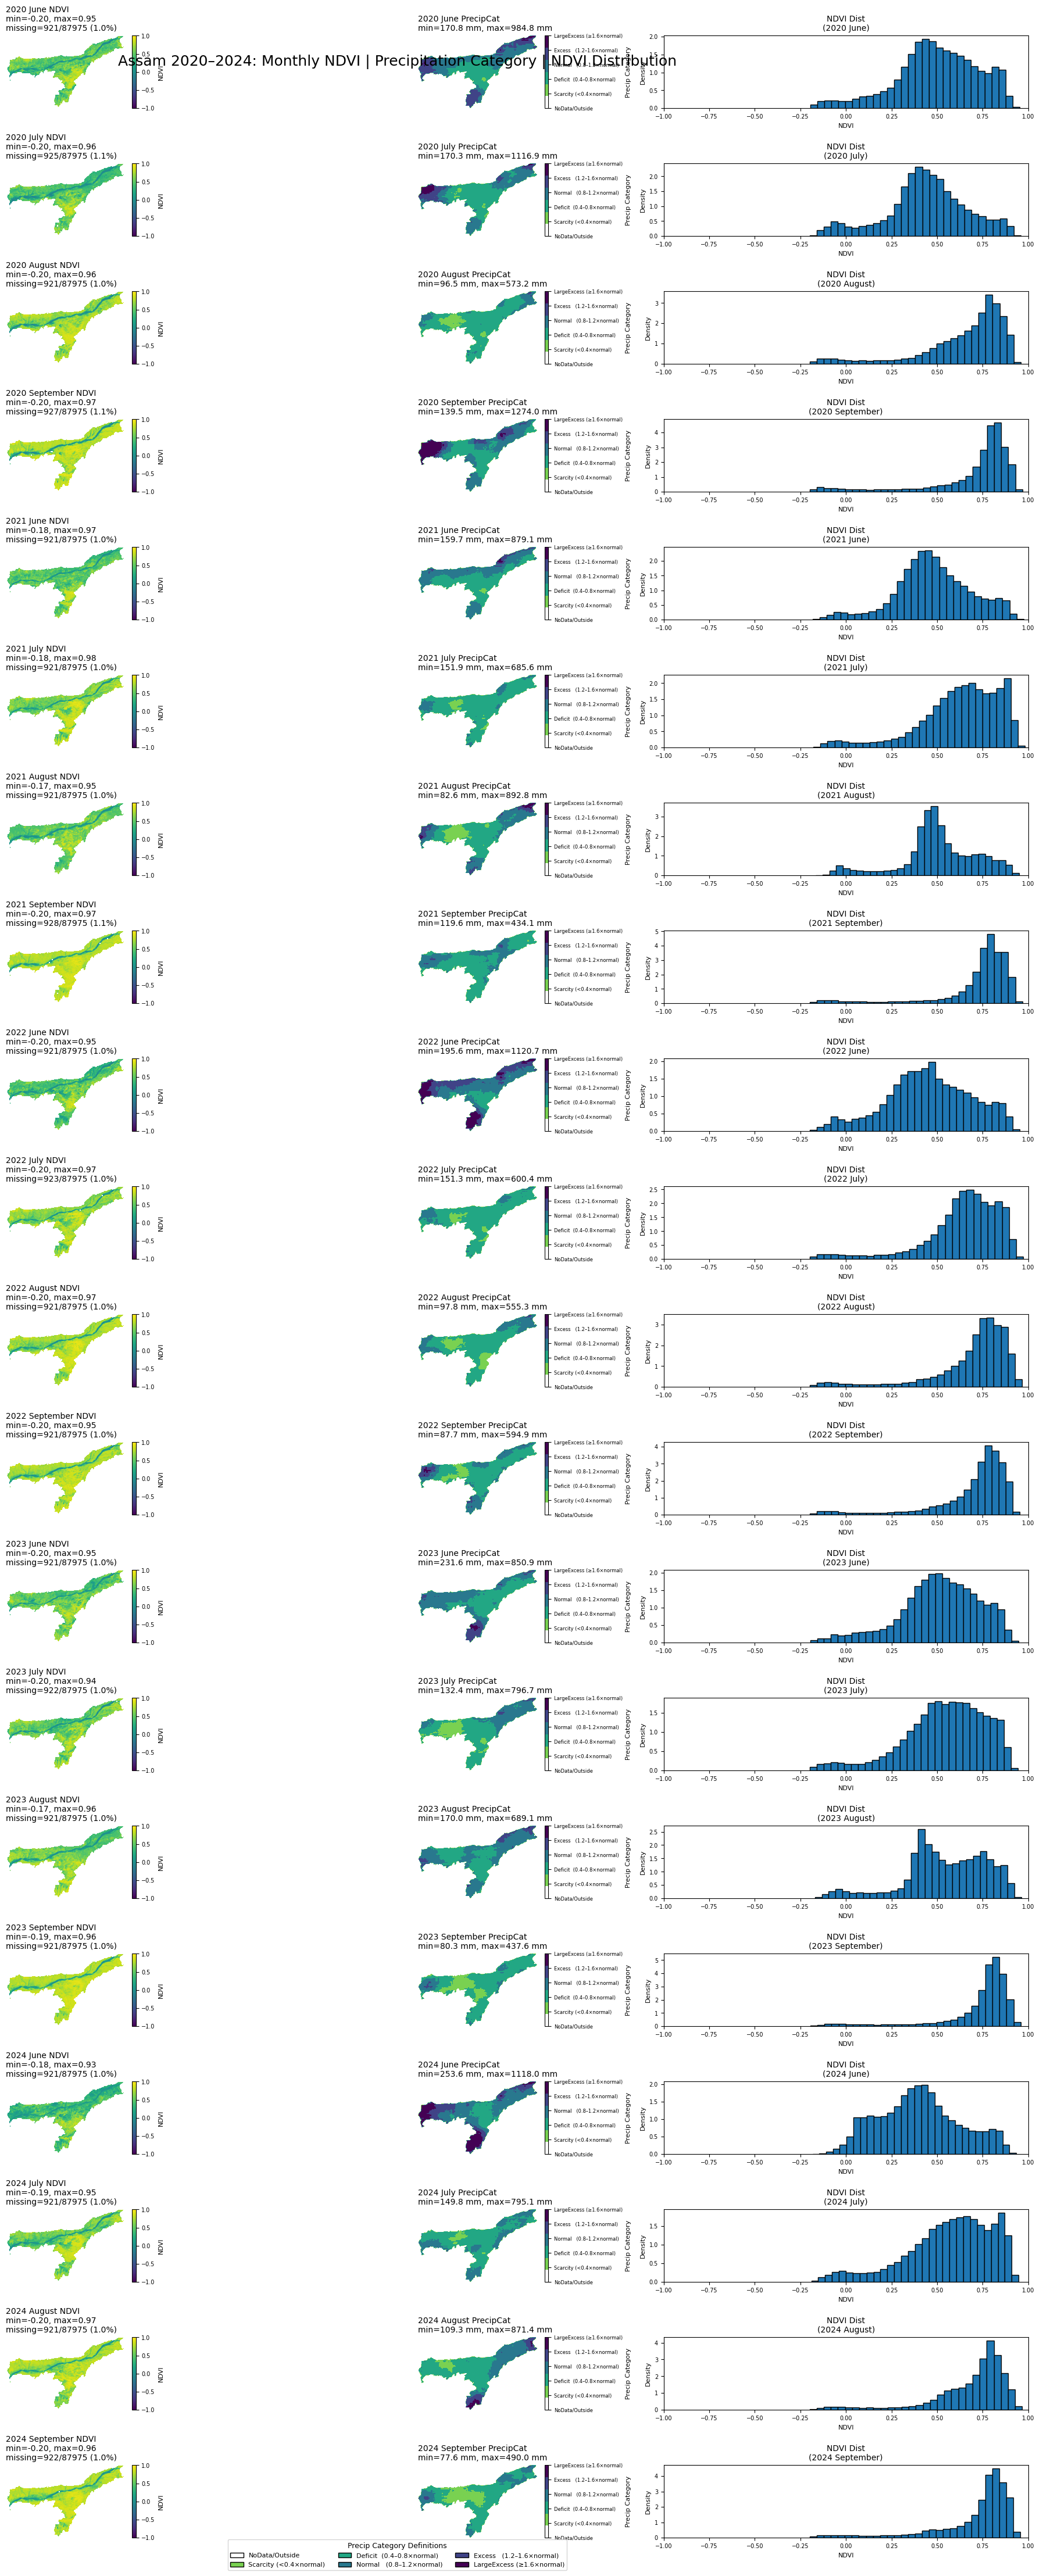

In [3]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Assam)
# -----------------------------------------------------------------------------
ndvi_tiff_path       = "Assam_X_NDVI.tif"
precip_raw_tiff_path = "Assam_Y_Precipitation_CHIRPS.tif"
precip_cat_tiff_path = "Assam_Y_Precipitation_GT_geotif.tif"
india_shapefile      = "SateMask/gadm41_IND_1.shp"  # contains Assam polygon

for path in (ndvi_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Cannot find {path!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE 20-BAND NDVI TIFF (2020–2024 × 4 months)
# -----------------------------------------------------------------------------
with rasterio.open(ndvi_tiff_path) as src_nd:
    ndvi_bands     = src_nd.read().astype(np.float32)  # shape = (20, H, W)
    ndvi_transform = src_nd.transform
    ndvi_crs       = src_nd.crs
    height, width  = src_nd.height, src_nd.width
    bounds         = src_nd.bounds

n_ndvi_bands = ndvi_bands.shape[0]
if n_ndvi_bands != 20:
    raise ValueError(f"Expected 20 bands in {ndvi_tiff_path}, but found {n_ndvi_bands}")

# 2a) Load India shapefile and extract Assam, reproject to NDVI CRS
gdf = gpd.read_file(india_shapefile)
gdf_assam = gdf[gdf["NAME_1"].str.lower() == "assam"].copy()
if gdf_assam.empty:
    raise ValueError("No feature named 'Assam' found in shapefile.")

if gdf_assam.crs != ndvi_crs:
    gdf_assam = gdf_assam.to_crs(ndvi_crs)

# 2b) Use union_all() (avoiding deprecated unary_union)
assam_geom = [gdf_assam.geometry.union_all()]

# 2c) Build a boolean mask (True = inside Assam) and count pixels
assam_mask = geometry_mask(
    assam_geom,
    transform=ndvi_transform,
    invert=True,
    out_shape=(height, width)
)
total_inside = np.count_nonzero(assam_mask)
print(f"Total pixels inside Assam boundary: {total_inside}")

# 2d) Set pixels outside Assam → NaN
for i in range(n_ndvi_bands):
    band = ndvi_bands[i]
    band[~assam_mask] = np.nan
    ndvi_bands[i] = band

# -----------------------------------------------------------------------------
# 3) READ THE 25-BAND RAW PRECIPITATION TIFF (in mm)
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src_pr_raw:
    precip_raw_full = src_pr_raw.read().astype(np.float32)  # shape = (25, H, W)

n_pr_raw_bands = precip_raw_full.shape[0]
if n_pr_raw_bands != 25:
    raise ValueError(f"Expected 25 bands in {precip_raw_tiff_path}, but found {n_pr_raw_bands}")

# 3a) Mask raw precipitation outside Assam → NaN
for i in range(n_pr_raw_bands):
    arr = precip_raw_full[i]
    arr[~assam_mask] = np.nan
    precip_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 4) READ THE 25-BAND PRECIPITATION CATEGORY TIFF (codes –1..4)
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src_pr_cat:
    precip_cat_full = src_pr_cat.read().astype(np.int8)  # shape = (25, H, W)

n_pr_cat_bands = precip_cat_full.shape[0]
if n_pr_cat_bands != 25:
    raise ValueError(f"Expected 25 bands in {precip_cat_tiff_path}, but found {n_pr_cat_bands}")

# 4a) Mask precip categories outside Assam → code = -1
for i in range(n_pr_cat_bands):
    arr = precip_cat_full[i]
    arr[~assam_mask] = -1
    precip_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 5) EXTRACT THE 20 MONTHLY PRECIPITATION BANDS
#    (drop each year's “Total” at indices 4, 9, 14, 19, 24)
# -----------------------------------------------------------------------------
monthly_indices = []
for yr_idx in range(5):
    base = yr_idx * 5
    monthly_indices.extend([base + 0, base + 1, base + 2, base + 3])

precip_raw_bands = precip_raw_full[monthly_indices, :, :]  # shape = (20, H, W)
precip_cat_bands = precip_cat_full[monthly_indices, :, :]  # shape = (20, H, W)

# -----------------------------------------------------------------------------
# 6) DEFINE YEARS & MONTHS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
month_names = ["June", "July", "August", "September"]
n_years     = len(years)       # 5
n_months    = len(month_names) # 4
n_total     = n_years * n_months  # 20

# -----------------------------------------------------------------------------
# 7) PREPARE COLORMAPS & STATISTICS
# -----------------------------------------------------------------------------
# 7a) NDVI colormap: continuous “viridis” from –1 to 1
ndvi_cmap = plt.get_cmap("viridis")
ndvi_vmin, ndvi_vmax = -1.0, 1.0

# 7b) Precip category palette (0..5 after shifting)
cluster_colors = [
    "#ffffff",  # 0 = NoData/Outside (orig code –1)
    "#79d151",  # 1 = Scarcity      (orig code 0)
    "#22a784",  # 2 = Deficit       (orig code 1)
    "#29788e",  # 3 = Normal        (orig code 2)
    "#404387",  # 4 = Excess        (orig code 3)
    "#440154"   # 5 = LargeExcess   (orig code 4)
]
cluster_cmap = ListedColormap(cluster_colors)
cluster_labels = {
    0: "NoData/Outside",
    1: "Scarcity (<0.4×normal)",
    2: "Deficit  (0.4–0.8×normal)",
    3: "Normal   (0.8–1.2×normal)",
    4: "Excess   (1.2–1.6×normal)",
    5: "LargeExcess (≥1.6×normal)"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(len(cluster_colors))
]

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE: 20 ROWS × 3 COLUMNS
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=n_total,
    ncols=3,
    figsize=(22, n_total * 2.2),
    constrained_layout=True
)
fig.suptitle(
    "Assam 2020–2024: Monthly NDVI | Precipitation Category | NDVI Distribution",
    fontsize=18, y=0.98
)

if n_total == 1:
    axes = axes[np.newaxis, :]

# -----------------------------------------------------------------------------
# 9) LOOP OVER ALL 20 MONTHS
# -----------------------------------------------------------------------------
for i in range(n_total):
    yr_idx = i // n_months
    mo_idx = i % n_months
    year   = years[yr_idx]
    month  = month_names[mo_idx]

    # NDVI stats
    ndvi_layer   = ndvi_bands[i]
    valid_ndvi   = ndvi_layer[~np.isnan(ndvi_layer)]
    if valid_ndvi.size > 0:
        ndvi_min = float(np.nanmin(valid_ndvi))
        ndvi_max = float(np.nanmax(valid_ndvi))
    else:
        ndvi_min = ndvi_max = None
    missing_count = np.count_nonzero(np.isnan(ndvi_layer[assam_mask]))
    missing_pct   = (missing_count / total_inside) * 100
    print(f"{year} {month} → Missing NDVI: {missing_count}/{total_inside} ({missing_pct:.2f}%)")

    # Raw precip stats
    raw_pr_layer = precip_raw_bands[i]
    valid_pr     = raw_pr_layer[~np.isnan(raw_pr_layer)]
    if valid_pr.size > 0:
        pr_min = float(np.nanmin(valid_pr))
        pr_max = float(np.nanmax(valid_pr))
    else:
        pr_min = pr_max = None

    # Precip category map
    raw_clust    = precip_cat_bands[i]
    cluster_plot = np.full(raw_clust.shape, 0, dtype=np.int8)
    mask_valid   = (raw_clust != -1)
    cluster_plot[mask_valid] = raw_clust[mask_valid] + 1

    # Column 0: NDVI Map
    ax0 = axes[i, 0]
    im0 = ax0.imshow(
        ndvi_layer, cmap=ndvi_cmap,
        vmin=ndvi_vmin, vmax=ndvi_vmax,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
        origin="upper"
    )
    title0 = f"{year} {month} NDVI"
    if ndvi_min is not None:
        title0 += f"\nmin={ndvi_min:.2f}, max={ndvi_max:.2f}"
    title0 += f"\nmissing={missing_count}/{total_inside} ({missing_pct:.1f}%)"
    ax0.set_title(title0, fontsize=10, loc="left")
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, orientation="vertical", fraction=0.045, pad=0.02)
    c0.set_label("NDVI", fontsize=8)
    c0.ax.tick_params(labelsize=7)

    # Column 1: Precip Cat Map
    ax1 = axes[i, 1]
    im1 = ax1.imshow(
        cluster_plot, cmap=cluster_cmap,
        vmin=0, vmax=5,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
        origin="upper"
    )
    title1 = f"{year} {month} PrecipCat"
    if pr_min is not None:
        title1 += f"\nmin={pr_min:.1f} mm, max={pr_max:.1f} mm"
    ax1.set_title(title1, fontsize=10, loc="left")
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, orientation="vertical", fraction=0.045, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5])
    c1.set_ticklabels([cluster_labels[j] for j in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=6)
    c1.set_label("Precip Category", fontsize=8)

    # Column 2: NDVI Distribution
    ax2 = axes[i, 2]
    if valid_ndvi.size > 0:
        ax2.hist(valid_ndvi.flatten(), bins=30, density=True, edgecolor="black")
        ax2.set_xlim(ndvi_vmin, ndvi_vmax)
    else:
        ax2.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=8, color="gray")
    ax2.set_title(f"NDVI Dist\n({year} {month})", fontsize=10)
    ax2.set_xlabel("NDVI", fontsize=8)
    ax2.set_ylabel("Density", fontsize=8)
    ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 10) Legend for Precipitation Categories
# -----------------------------------------------------------------------------
fig.legend(
    handles=cluster_handles,
    loc="lower center",
    ncol=3,
    frameon=True,
    title="Precip Category Definitions",
    bbox_to_anchor=(0.5, -0.005),
    fontsize=8,
    title_fontsize=9
)

plt.show()


In [ ]:
##Assam_Relative_Humidity_missing_values

In [ ]:
##Assam_wind_speed_missing_values

Total pixels inside Assam: 87975
2020 June → Wind missing: 921/87975 (1.05%)
2020 June → Precip missing: 921/87975 (1.05%)
2020 July → Wind missing: 921/87975 (1.05%)
2020 July → Precip missing: 921/87975 (1.05%)
2020 August → Wind missing: 921/87975 (1.05%)
2020 August → Precip missing: 921/87975 (1.05%)
2020 September → Wind missing: 921/87975 (1.05%)
2020 September → Precip missing: 921/87975 (1.05%)
2021 June → Wind missing: 921/87975 (1.05%)
2021 June → Precip missing: 921/87975 (1.05%)
2021 July → Wind missing: 921/87975 (1.05%)
2021 July → Precip missing: 921/87975 (1.05%)
2021 August → Wind missing: 921/87975 (1.05%)
2021 August → Precip missing: 921/87975 (1.05%)
2021 September → Wind missing: 921/87975 (1.05%)
2021 September → Precip missing: 921/87975 (1.05%)
2022 June → Wind missing: 921/87975 (1.05%)
2022 June → Precip missing: 921/87975 (1.05%)
2022 July → Wind missing: 921/87975 (1.05%)
2022 July → Precip missing: 921/87975 (1.05%)
2022 August → Wind missing: 921/87975 (

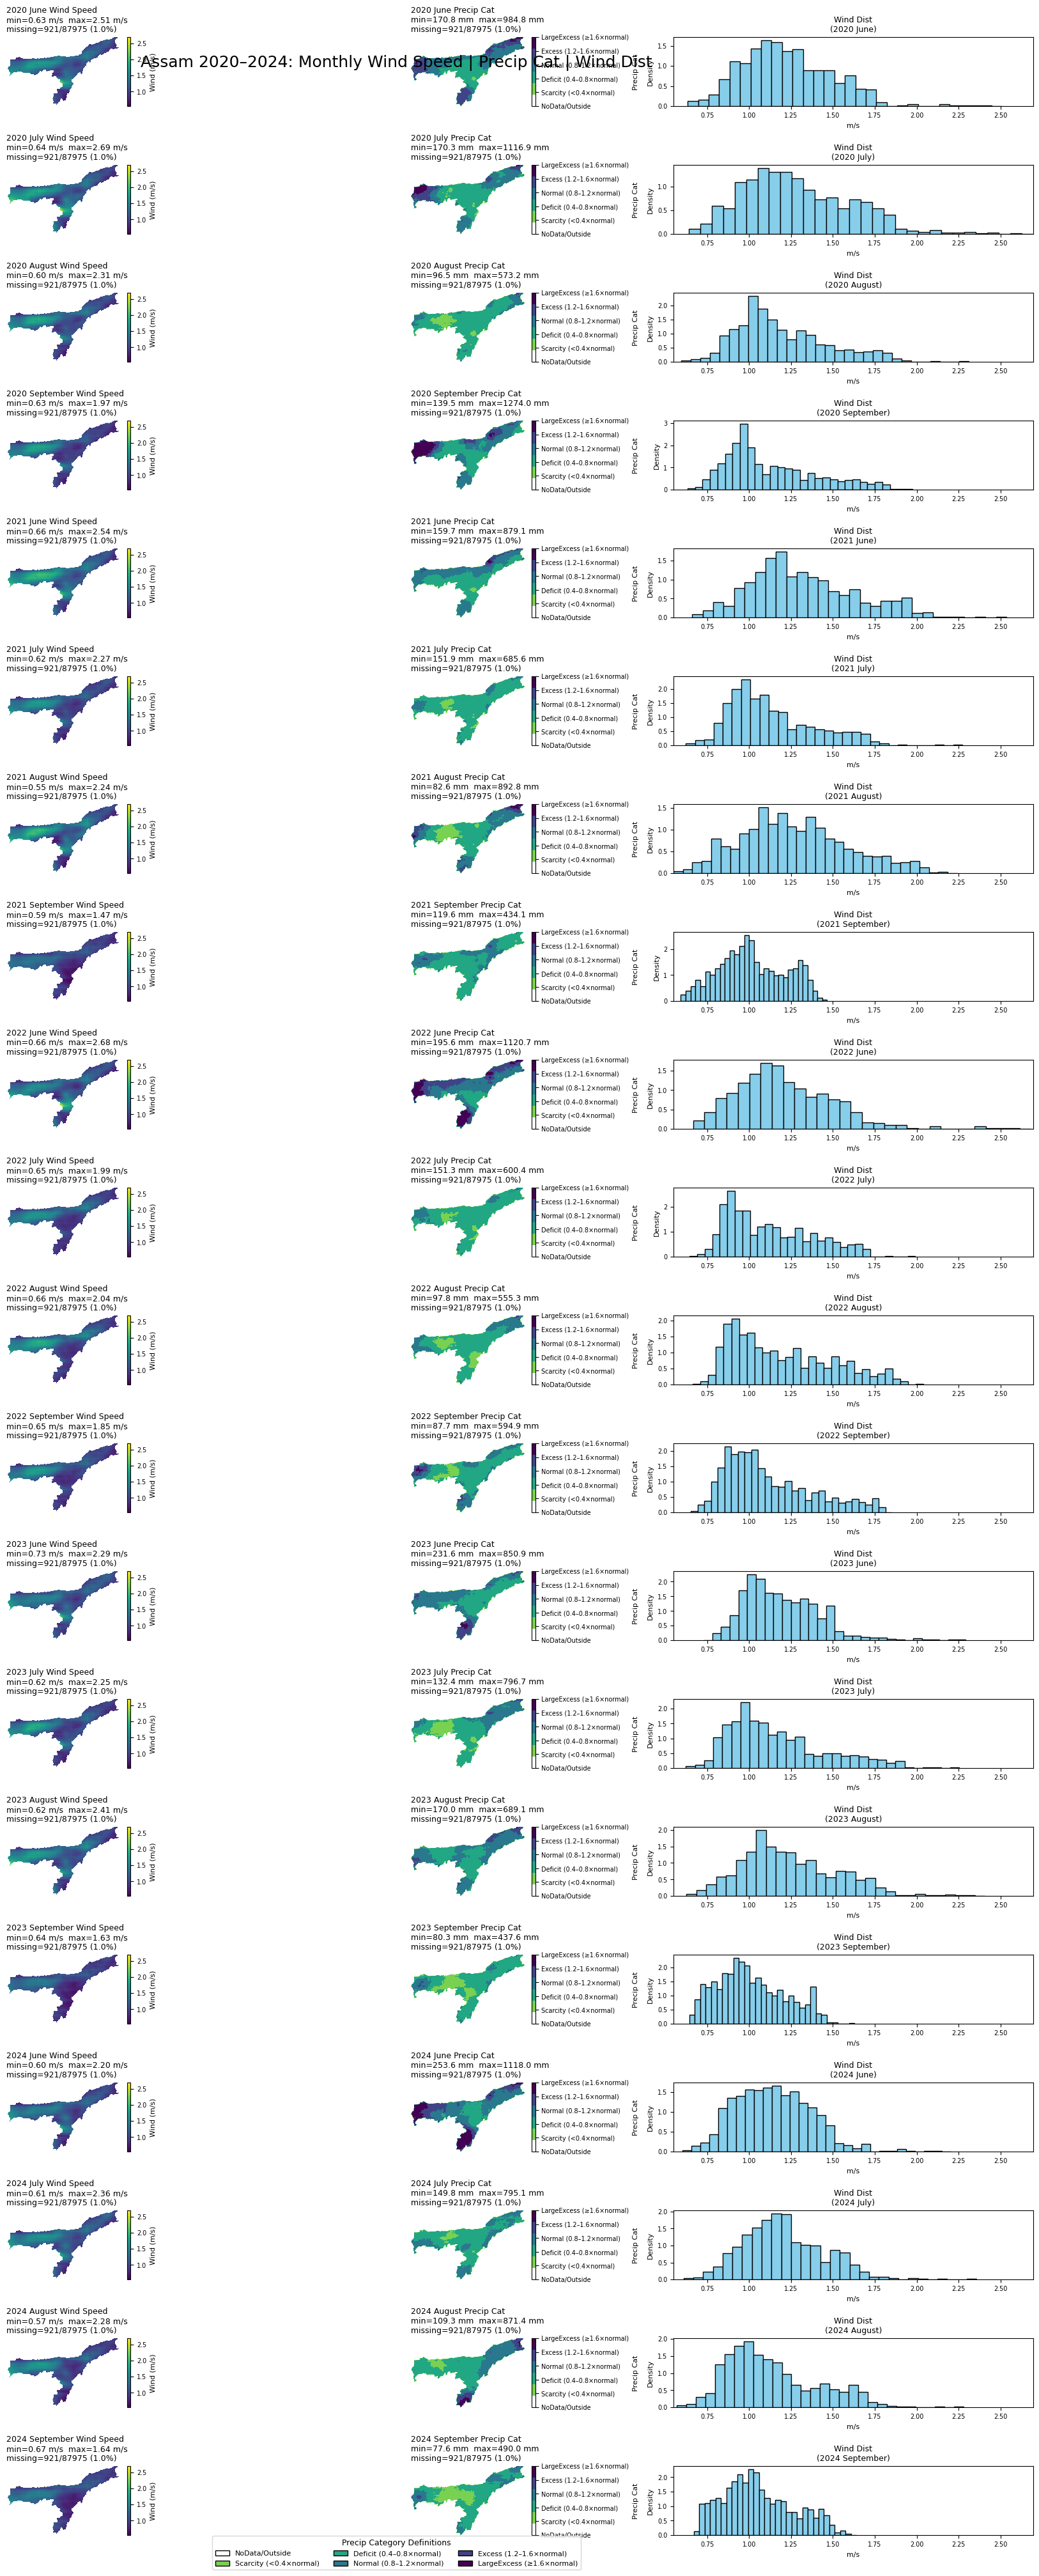

In [7]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Assam)
# -----------------------------------------------------------------------------
wind_tiff_path        = "Assam_X_Wind_Speed.tif"               # 20 bands (2020–2024 × 4 months)
precip_raw_tiff_path  = "Assam_Y_Precipitation_CHIRPS.tif"      # 25 bands (2020–2024 × 5)
precip_cat_tiff_path  = "Assam_Y_Precipitation_GT_geotif.tif"   # 25 bands (2020–2024 × 5)
india_shapefile       = "SateMask/gadm41_IND_1.shp"            # contains all Indian states

for p in (wind_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE WIND SPEED TIFF
# -----------------------------------------------------------------------------
with rasterio.open(wind_tiff_path) as src:
    wind_bands     = src.read().astype(np.float32)  # (20, H, W)
    wind_transform = src.transform
    wind_crs       = src.crs
    height, width  = src.height, src.width
    bounds         = src.bounds

if wind_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {wind_tiff_path}, found {wind_bands.shape[0]}")

# 2a) Assam mask
gdf = gpd.read_file(india_shapefile)
gdf_assam = gdf[gdf["NAME_1"].str.lower() == "assam"].copy()
if gdf_assam.empty:
    raise ValueError("No 'Assam' feature found in shapefile.")

if gdf_assam.crs != wind_crs:
    gdf_assam = gdf_assam.to_crs(wind_crs)

assam_geom = [gdf_assam.geometry.union_all()]
assam_mask = geometry_mask(
    assam_geom,
    transform=wind_transform,
    invert=True,
    out_shape=(height, width)
)
total_inside = np.count_nonzero(assam_mask)
print(f"Total pixels inside Assam: {total_inside}")

# Mask outside → NaN
for i in range(wind_bands.shape[0]):
    band = wind_bands[i]
    band[~assam_mask] = np.nan
    wind_bands[i] = band

# -----------------------------------------------------------------------------
# 3) READ & MASK RAW PRECIPITATION
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src:
    pr_raw_full = src.read().astype(np.float32)  # (25, H, W)

if pr_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in raw precip, found {pr_raw_full.shape[0]}")

for i in range(pr_raw_full.shape[0]):
    arr = pr_raw_full[i]
    arr[~assam_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 4) READ & MASK PRECIPITATION CATEGORY
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src:
    pr_cat_full = src.read().astype(np.int8)  # (25, H, W)

if pr_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in precip cat, found {pr_cat_full.shape[0]}")

for i in range(pr_cat_full.shape[0]):
    arr = pr_cat_full[i]
    arr[~assam_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 5) EXTRACT 20 MONTHLY PRECIP BANDS (drop indices 4,9,14,19,24)
# -----------------------------------------------------------------------------
monthly_idxs = []
for y in range(5):
    base = y * 5
    monthly_idxs += [base + m for m in range(4)]

precip_raw_bands = pr_raw_full[monthly_idxs]  # (20,H,W)
precip_cat_bands = pr_cat_full[monthly_idxs]  # (20,H,W)

# -----------------------------------------------------------------------------
# 6) YEARS & MONTHS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
months      = ["June", "July", "August", "September"]
n_years, n_months = len(years), len(months)
n_total     = n_years * n_months  # 20

# -----------------------------------------------------------------------------
# 7) COLORMAPS & GLOBAL STATS
# -----------------------------------------------------------------------------
# Wind speed range
vals_ws    = wind_bands.flatten()[~np.isnan(wind_bands.flatten())]
wind_vmin  = float(np.nanmin(vals_ws)) if vals_ws.size else 0.0
wind_vmax  = float(np.nanmax(vals_ws)) if vals_ws.size else 1.0
wind_cmap  = plt.get_cmap("viridis")

# Precip category
cluster_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
cluster_cmap    = ListedColormap(cluster_colors)
cluster_labels  = {
    0: "NoData/Outside",
    1: "Scarcity (<0.4×normal)",
    2: "Deficit (0.4–0.8×normal)",
    3: "Normal (0.8–1.2×normal)",
    4: "Excess (1.2–1.6×normal)",
    5: "LargeExcess (≥1.6×normal)"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(6)
]

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(n_total, 3, figsize=(20, n_total*2.0), constrained_layout=True)
fig.suptitle("Assam 2020–2024: Monthly Wind Speed | Precip Cat | Wind Dist", fontsize=18, y=0.98)
if n_total == 1:
    axes = axes[np.newaxis, :]

# -----------------------------------------------------------------------------
# 9) LOOP & PLOT WITH MISSING STATS
# -----------------------------------------------------------------------------
for i in range(n_total):
    y_idx, m_idx = divmod(i, n_months)
    year, mon    = years[y_idx], months[m_idx]

    # Wind stats & missing
    ws_layer = wind_bands[i]
    valid_ws = ws_layer[~np.isnan(ws_layer)]
    ws_min   = float(np.nanmin(valid_ws)) if valid_ws.size else np.nan
    ws_max   = float(np.nanmax(valid_ws)) if valid_ws.size else np.nan
    miss_ws  = np.count_nonzero(np.isnan(ws_layer[assam_mask]))
    pct_ws   = miss_ws / total_inside * 100
    print(f"{year} {mon} → Wind missing: {miss_ws}/{total_inside} ({pct_ws:.2f}%)")

    # Raw precip stats & missing
    pr_layer = precip_raw_bands[i]
    valid_pr = pr_layer[~np.isnan(pr_layer)]
    pr_min   = float(np.nanmin(valid_pr)) if valid_pr.size else np.nan
    pr_max   = float(np.nanmax(valid_pr)) if valid_pr.size else np.nan
    miss_pr  = np.count_nonzero(np.isnan(pr_layer[assam_mask]))
    pct_pr   = miss_pr / total_inside * 100
    print(f"{year} {mon} → Precip missing: {miss_pr}/{total_inside} ({pct_pr:.2f}%)")

    # Precip category map
    cat        = precip_cat_bands[i]
    cat_plot   = np.zeros_like(cat, dtype=np.int8)
    mask_valid = (cat != -1)
    cat_plot[mask_valid] = cat[mask_valid] + 1  # codes 1..5

    # — Column 0: Wind Speed Map —
    ax0 = axes[i, 0]
    im0 = ax0.imshow(ws_layer, cmap=wind_cmap, vmin=wind_vmin, vmax=wind_vmax,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                     origin="upper")
    title0 = (
        f"{year} {mon} Wind Speed\n"
        f"min={ws_min:.2f} m/s  max={ws_max:.2f} m/s\n"
        f"missing={miss_ws}/{total_inside} ({pct_ws:.1f}%)"
    )
    ax0.set_title(title0, loc="left", fontsize=9)
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, fraction=0.045, pad=0.02)
    c0.set_label("Wind (m/s)", fontsize=8); c0.ax.tick_params(labelsize=7)

    # — Column 1: Precip Category —
    ax1 = axes[i, 1]
    im1 = ax1.imshow(cat_plot, cmap=cluster_cmap, vmin=0, vmax=5,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                     origin="upper")
    title1 = (
        f"{year} {mon} Precip Cat\n"
        f"min={pr_min:.1f} mm  max={pr_max:.1f} mm\n"
        f"missing={miss_pr}/{total_inside} ({pct_pr:.1f}%)"
    )
    ax1.set_title(title1, loc="left", fontsize=9)
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, fraction=0.045, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5])
    c1.set_ticklabels([cluster_labels[j] for j in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=7); c1.set_label("Precip Cat", fontsize=8)

    # — Column 2: Wind Speed Distribution —
    ax2 = axes[i, 2]
    if valid_ws.size:
        ax2.hist(valid_ws.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(wind_vmin, wind_vmax)
    else:
        ax2.text(0.5,0.5,"No Data",ha="center",va="center",fontsize=8,color="gray")
    ax2.set_title(f"Wind Dist\n({year} {mon})", fontsize=9)
    ax2.set_xlabel("m/s", fontsize=8); ax2.set_ylabel("Density", fontsize=8)
    ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 10) Legend for Precipitation Categories
# -----------------------------------------------------------------------------
fig.legend(
    handles=cluster_handles,
    labels=[cluster_labels[i] for i in range(len(cluster_handles))],
    loc="lower center",
    ncol=3,
    frameon=True,
    title="Precip Category Definitions",
    fontsize=8,
    title_fontsize=9,
    bbox_to_anchor=(0.5, -0.005)
)

plt.show()


In [ ]:
##Assam_LULC_missing_values

Total pixels inside Assam: 87975
2020 June → LULC missing: 0/87975 (0.00%)
2020 June → Precip missing: 921/87975 (1.05%)
2020 July → LULC missing: 0/87975 (0.00%)
2020 July → Precip missing: 921/87975 (1.05%)
2020 August → LULC missing: 0/87975 (0.00%)
2020 August → Precip missing: 921/87975 (1.05%)
2020 September → LULC missing: 0/87975 (0.00%)
2020 September → Precip missing: 921/87975 (1.05%)
2021 June → LULC missing: 0/87975 (0.00%)
2021 June → Precip missing: 921/87975 (1.05%)
2021 July → LULC missing: 0/87975 (0.00%)
2021 July → Precip missing: 921/87975 (1.05%)
2021 August → LULC missing: 0/87975 (0.00%)
2021 August → Precip missing: 921/87975 (1.05%)
2021 September → LULC missing: 0/87975 (0.00%)
2021 September → Precip missing: 921/87975 (1.05%)
2022 June → LULC missing: 0/87975 (0.00%)
2022 June → Precip missing: 921/87975 (1.05%)
2022 July → LULC missing: 0/87975 (0.00%)
2022 July → Precip missing: 921/87975 (1.05%)
2022 August → LULC missing: 0/87975 (0.00%)
2022 August → P

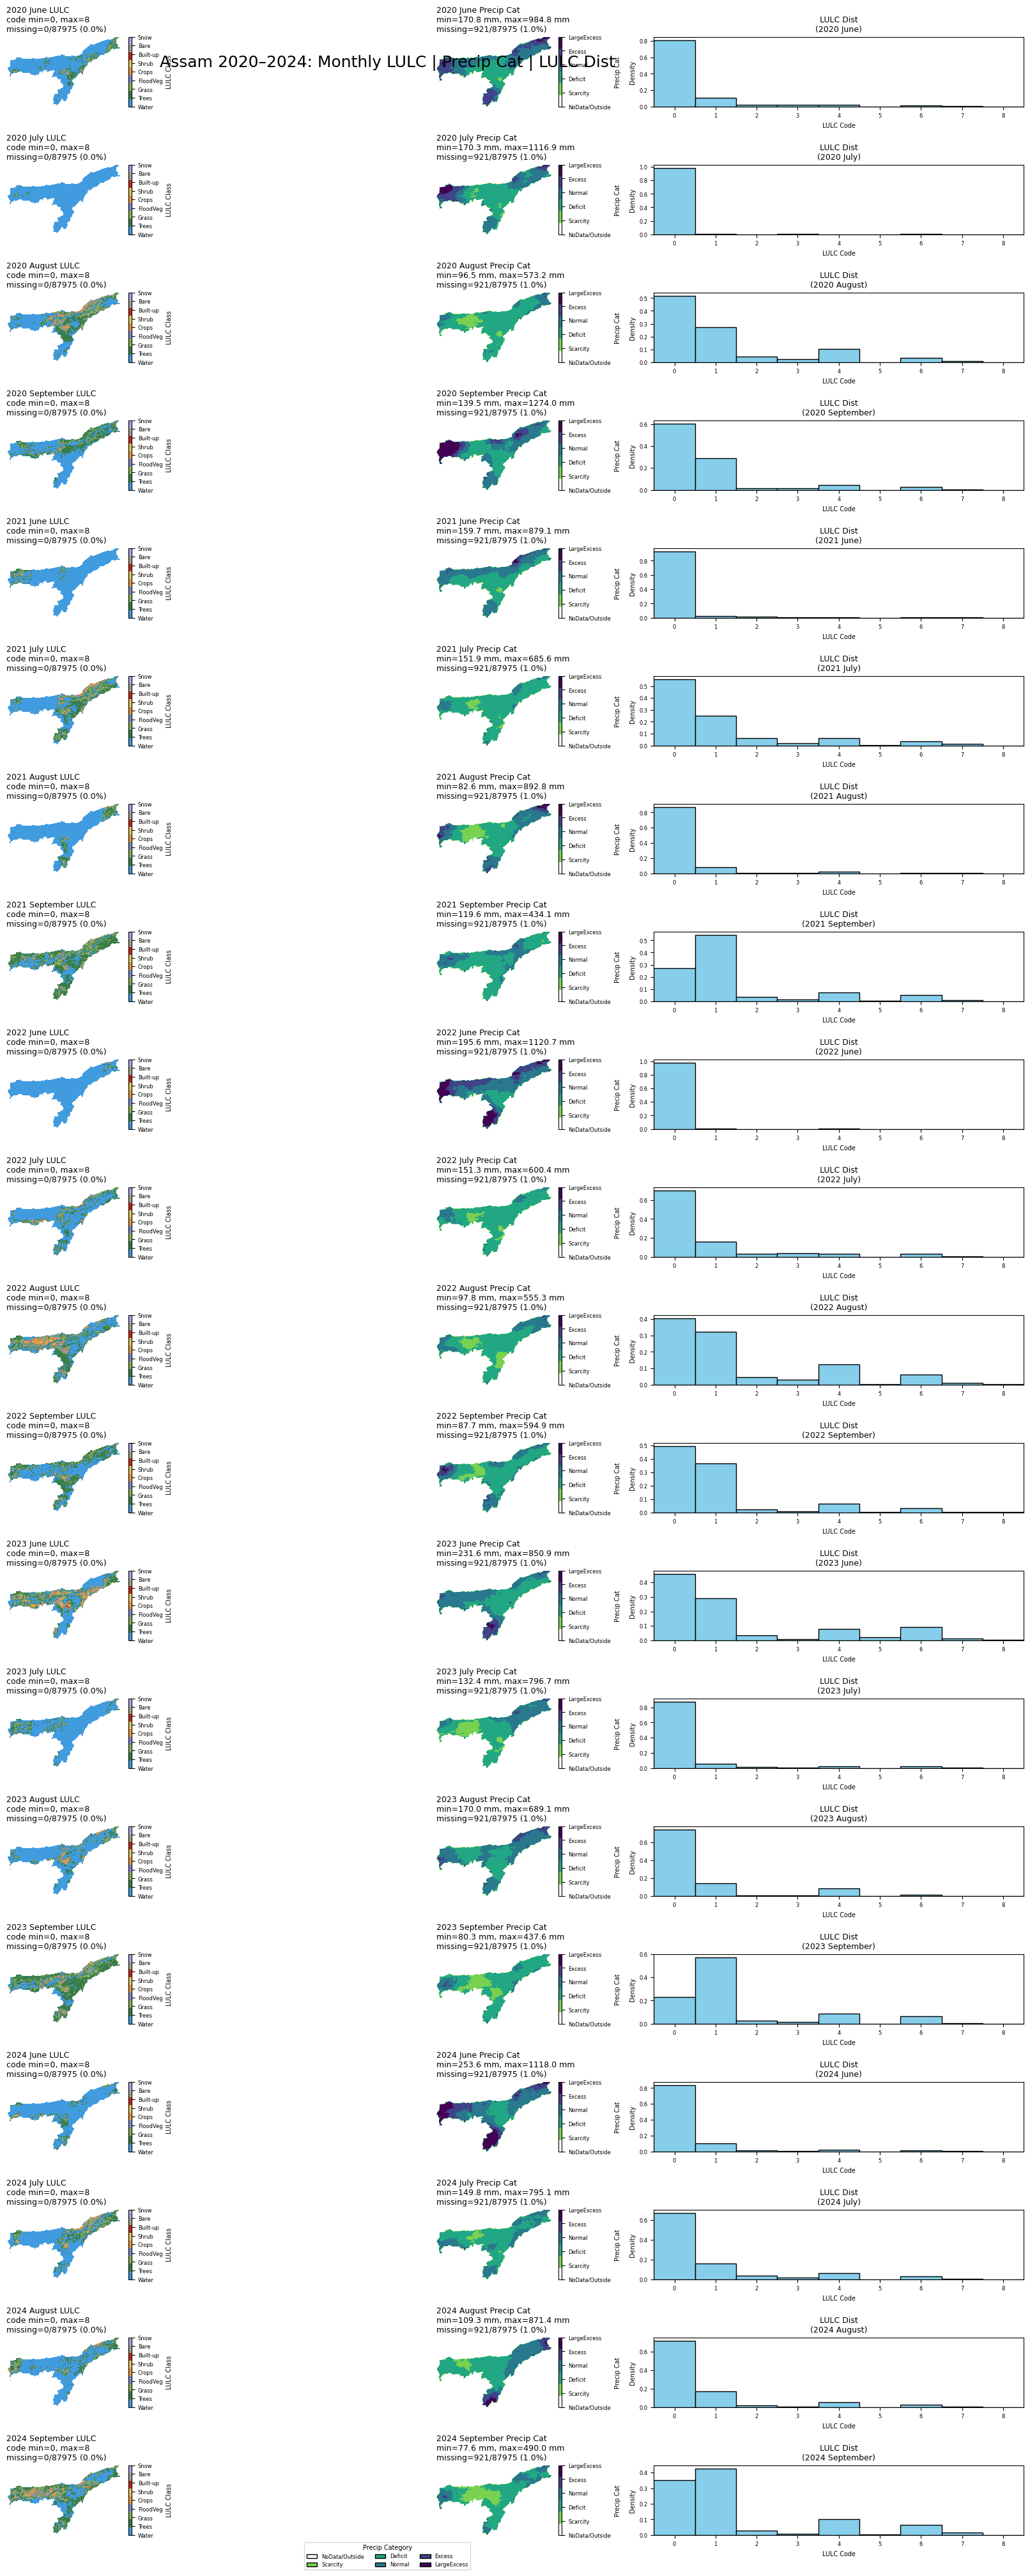

In [9]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Assam)
# -----------------------------------------------------------------------------
lulc_tiff_path        = "Assam_X_LULC.tif"
precip_raw_tiff_path  = "Assam_Y_Precipitation_CHIRPS.tif"
precip_cat_tiff_path  = "Assam_Y_Precipitation_GT_geotif.tif"
india_shapefile       = "SateMask/gadm41_IND_1.shp"  # contains all Indian states

for path in (lulc_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Cannot find {path!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE 20‐BAND LULC TIFF
# -----------------------------------------------------------------------------
with rasterio.open(lulc_tiff_path) as src_lulc:
    lulc_bands     = src_lulc.read().astype(np.float32)  # (20, H, W)
    transform      = src_lulc.transform
    crs            = src_lulc.crs
    height, width  = src_lulc.height, src_lulc.width
    bounds         = src_lulc.bounds

if lulc_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {lulc_tiff_path}, found {lulc_bands.shape[0]}")

# Load Assam polygon & build mask
gdf = gpd.read_file(india_shapefile)
gdf_assam = gdf[gdf["NAME_1"].str.lower() == "assam"].copy()
if gdf_assam.empty:
    raise ValueError("No 'Assam' feature found in shapefile.")
if gdf_assam.crs != crs:
    gdf_assam = gdf_assam.to_crs(crs)

assam_geom = [gdf_assam.geometry.union_all()]
assam_mask = geometry_mask(assam_geom, transform=transform, invert=True, out_shape=(height, width))
total_inside = np.count_nonzero(assam_mask)
print(f"Total pixels inside Assam: {total_inside}")

# Mask LULC outside Assam → NaN
for i in range(lulc_bands.shape[0]):
    band = lulc_bands[i]
    band[~assam_mask] = np.nan
    lulc_bands[i] = band

# -----------------------------------------------------------------------------
# 3) READ & MASK RAW PRECIPITATION (25 bands)
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src_pr:
    precip_raw_full = src_pr.read().astype(np.float32)  # (25, H, W)
if precip_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in raw precip, found {precip_raw_full.shape[0]}")
for i in range(25):
    arr = precip_raw_full[i]
    arr[~assam_mask] = np.nan
    precip_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 4) READ & MASK PRECIPITATION CATEGORY (25 bands)
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src_pc:
    precip_cat_full = src_pc.read().astype(np.int8)  # (25, H, W)
if precip_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in precip cat, found {precip_cat_full.shape[0]}")
for i in range(25):
    arr = precip_cat_full[i]
    arr[~assam_mask] = -1
    precip_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 5) EXTRACT 20 MONTHLY PRECIP BANDS (drop totals at 4,9,14,19,24)
# -----------------------------------------------------------------------------
monthly_idxs = []
for yr in range(5):
    base = yr * 5
    monthly_idxs += [base + m for m in range(4)]
precip_raw_bands = precip_raw_full[monthly_idxs]
precip_cat_bands = precip_cat_full[monthly_idxs]

# -----------------------------------------------------------------------------
# 6) DEFINE YEARS & MONTHS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
month_names = ["June", "July", "August", "September"]
n_years, n_months = len(years), len(month_names)
n_total     = n_years * n_months  # 20

# -----------------------------------------------------------------------------
# 7) PREPARE COLORMAPS & GLOBAL STATS
# -----------------------------------------------------------------------------
# Dynamic World LULC palette (9 classes)
dw_palette = ["#419bdf","#397d49","#88b053","#7a87c6","#e49635","#dfc35a","#c4281b","#a59b8f","#b39fe1"]
lulc_cmap, lulc_vmin, lulc_vmax = ListedColormap(dw_palette), 0, 8

# Precip category palette
cluster_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
cluster_cmap    = ListedColormap(cluster_colors)
cluster_labels  = {
    0:"NoData/Outside",1:"Scarcity",2:"Deficit",
    3:"Normal",4:"Excess",5:"LargeExcess"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(6)
]

# Overall precip raw min/max
all_pr = precip_raw_bands.flatten()
all_pr = all_pr[~np.isnan(all_pr)]
pr_vmin = float(np.nanmin(all_pr)) if all_pr.size else 0.0
pr_vmax = float(np.nanmax(all_pr)) if all_pr.size else 0.0

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(n_total, 3, figsize=(20, n_total*2.0), constrained_layout=True)
fig.suptitle("Assam 2020–2024: Monthly LULC | Precip Cat | LULC Dist", fontsize=18, y=0.98)
if n_total == 1:
    axes = axes[np.newaxis, :]

# -----------------------------------------------------------------------------
# 9) LOOP & PLOT WITH MISSING STATS
# -----------------------------------------------------------------------------
for i in range(n_total):
    y_idx, m_idx = divmod(i, n_months)
    year, mon    = years[y_idx], month_names[m_idx]

    # LULC stats + missing
    lulc_layer = lulc_bands[i]
    valid_lc   = lulc_layer[~np.isnan(lulc_layer)]
    lc_min = int(np.nanmin(valid_lc)) if valid_lc.size else None
    lc_max = int(np.nanmax(valid_lc)) if valid_lc.size else None
    miss_lc = np.count_nonzero(np.isnan(lulc_layer[assam_mask]))
    pct_lc  = miss_lc / total_inside * 100
    print(f"{year} {mon} → LULC missing: {miss_lc}/{total_inside} ({pct_lc:.2f}%)")

    # Precip raw stats + missing
    pr_layer = precip_raw_bands[i]
    valid_pr = pr_layer[~np.isnan(pr_layer)]
    pr_min = float(np.nanmin(valid_pr)) if valid_pr.size else None
    pr_max = float(np.nanmax(valid_pr)) if valid_pr.size else None
    miss_pr = np.count_nonzero(np.isnan(pr_layer[assam_mask]))
    pct_pr  = miss_pr / total_inside * 100
    print(f"{year} {mon} → Precip missing: {miss_pr}/{total_inside} ({pct_pr:.2f}%)")

    # Precip category map conversion
    raw_cat    = precip_cat_bands[i]
    cat_plot   = np.zeros_like(raw_cat, dtype=np.int8)
    valid_mask = (raw_cat != -1)
    cat_plot[valid_mask] = raw_cat[valid_mask] + 1

    # — Column 0: LULC Map —
    ax0 = axes[i, 0]
    im0 = ax0.imshow(lulc_layer, cmap=lulc_cmap, vmin=lulc_vmin, vmax=lulc_vmax,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                     origin="upper")
    title0 = f"{year} {mon} LULC"
    if lc_min is not None:
        title0 += f"\ncode min={lc_min}, max={lc_max}"
    title0 += f"\nmissing={miss_lc}/{total_inside} ({pct_lc:.1f}%)"
    ax0.set_title(title0, loc="left", fontsize=9)
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, fraction=0.04, pad=0.02)
    c0.set_ticks(np.arange(0, 9))
    c0.ax.set_yticklabels(
        ["Water","Trees","Grass","FloodVeg","Crops","Shrub","Built-up","Bare","Snow"],
        fontsize=6
    )
    c0.ax.tick_params(labelsize=6)
    c0.set_label("LULC Class", fontsize=7)

    # — Column 1: Precip Category Map —
    ax1 = axes[i, 1]
    im1 = ax1.imshow(cat_plot, cmap=cluster_cmap, vmin=0, vmax=5,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                     origin="upper")
    title1 = f"{year} {mon} Precip Cat\nmin={pr_min:.1f} mm, max={pr_max:.1f} mm"
    title1 += f"\nmissing={miss_pr}/{total_inside} ({pct_pr:.1f}%)"
    ax1.set_title(title1, loc="left", fontsize=9)
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, fraction=0.04, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5])
    c1.set_ticklabels([cluster_labels[i] for i in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=6)
    c1.set_label("Precip Cat", fontsize=7)

    # — Column 2: LULC Distribution —
    ax2 = axes[i, 2]
    if valid_lc.size:
        bins = np.arange(-0.5, 9.5, 1.0)
        ax2.hist(valid_lc.flatten(), bins=bins, density=True, edgecolor="black", color="skyblue")
        ax2.set_xticks(np.arange(0, 9))
        ax2.set_xticklabels(np.arange(0, 9), fontsize=6)
    else:
        ax2.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=8, color="gray")
    ax2.set_xlim(-0.5, 8.5)
    ax2.set_title(f"LULC Dist\n({year} {mon})", fontsize=9)
    ax2.set_xlabel("LULC Code", fontsize=7)
    ax2.set_ylabel("Density", fontsize=7)
    ax2.tick_params(labelsize=6)

# -----------------------------------------------------------------------------
# 10) LEGEND FOR PRECIP CATEGORIES
# -----------------------------------------------------------------------------
fig.legend(
    handles=cluster_handles,
    labels=[cluster_labels[i] for i in range(6)],
    loc="lower center",
    ncol=3,
    frameon=True,
    title="Precip Category",
    fontsize=6,
    title_fontsize=7,
    bbox_to_anchor=(0.5, -0.005)
)

plt.show()


In [ ]:
##Assam_soil_moisture_missing_values

Total pixels inside Assam: 87975
2020 June → SM missing: 921/87975 (1.05%)
2020 June → Precip missing: 921/87975 (1.05%)
2020 July → SM missing: 921/87975 (1.05%)
2020 July → Precip missing: 921/87975 (1.05%)
2020 August → SM missing: 921/87975 (1.05%)
2020 August → Precip missing: 921/87975 (1.05%)
2020 September → SM missing: 921/87975 (1.05%)
2020 September → Precip missing: 921/87975 (1.05%)
2021 June → SM missing: 921/87975 (1.05%)
2021 June → Precip missing: 921/87975 (1.05%)
2021 July → SM missing: 921/87975 (1.05%)
2021 July → Precip missing: 921/87975 (1.05%)
2021 August → SM missing: 921/87975 (1.05%)
2021 August → Precip missing: 921/87975 (1.05%)
2021 September → SM missing: 921/87975 (1.05%)
2021 September → Precip missing: 921/87975 (1.05%)
2022 June → SM missing: 921/87975 (1.05%)
2022 June → Precip missing: 921/87975 (1.05%)
2022 July → SM missing: 921/87975 (1.05%)
2022 July → Precip missing: 921/87975 (1.05%)
2022 August → SM missing: 921/87975 (1.05%)
2022 August → P

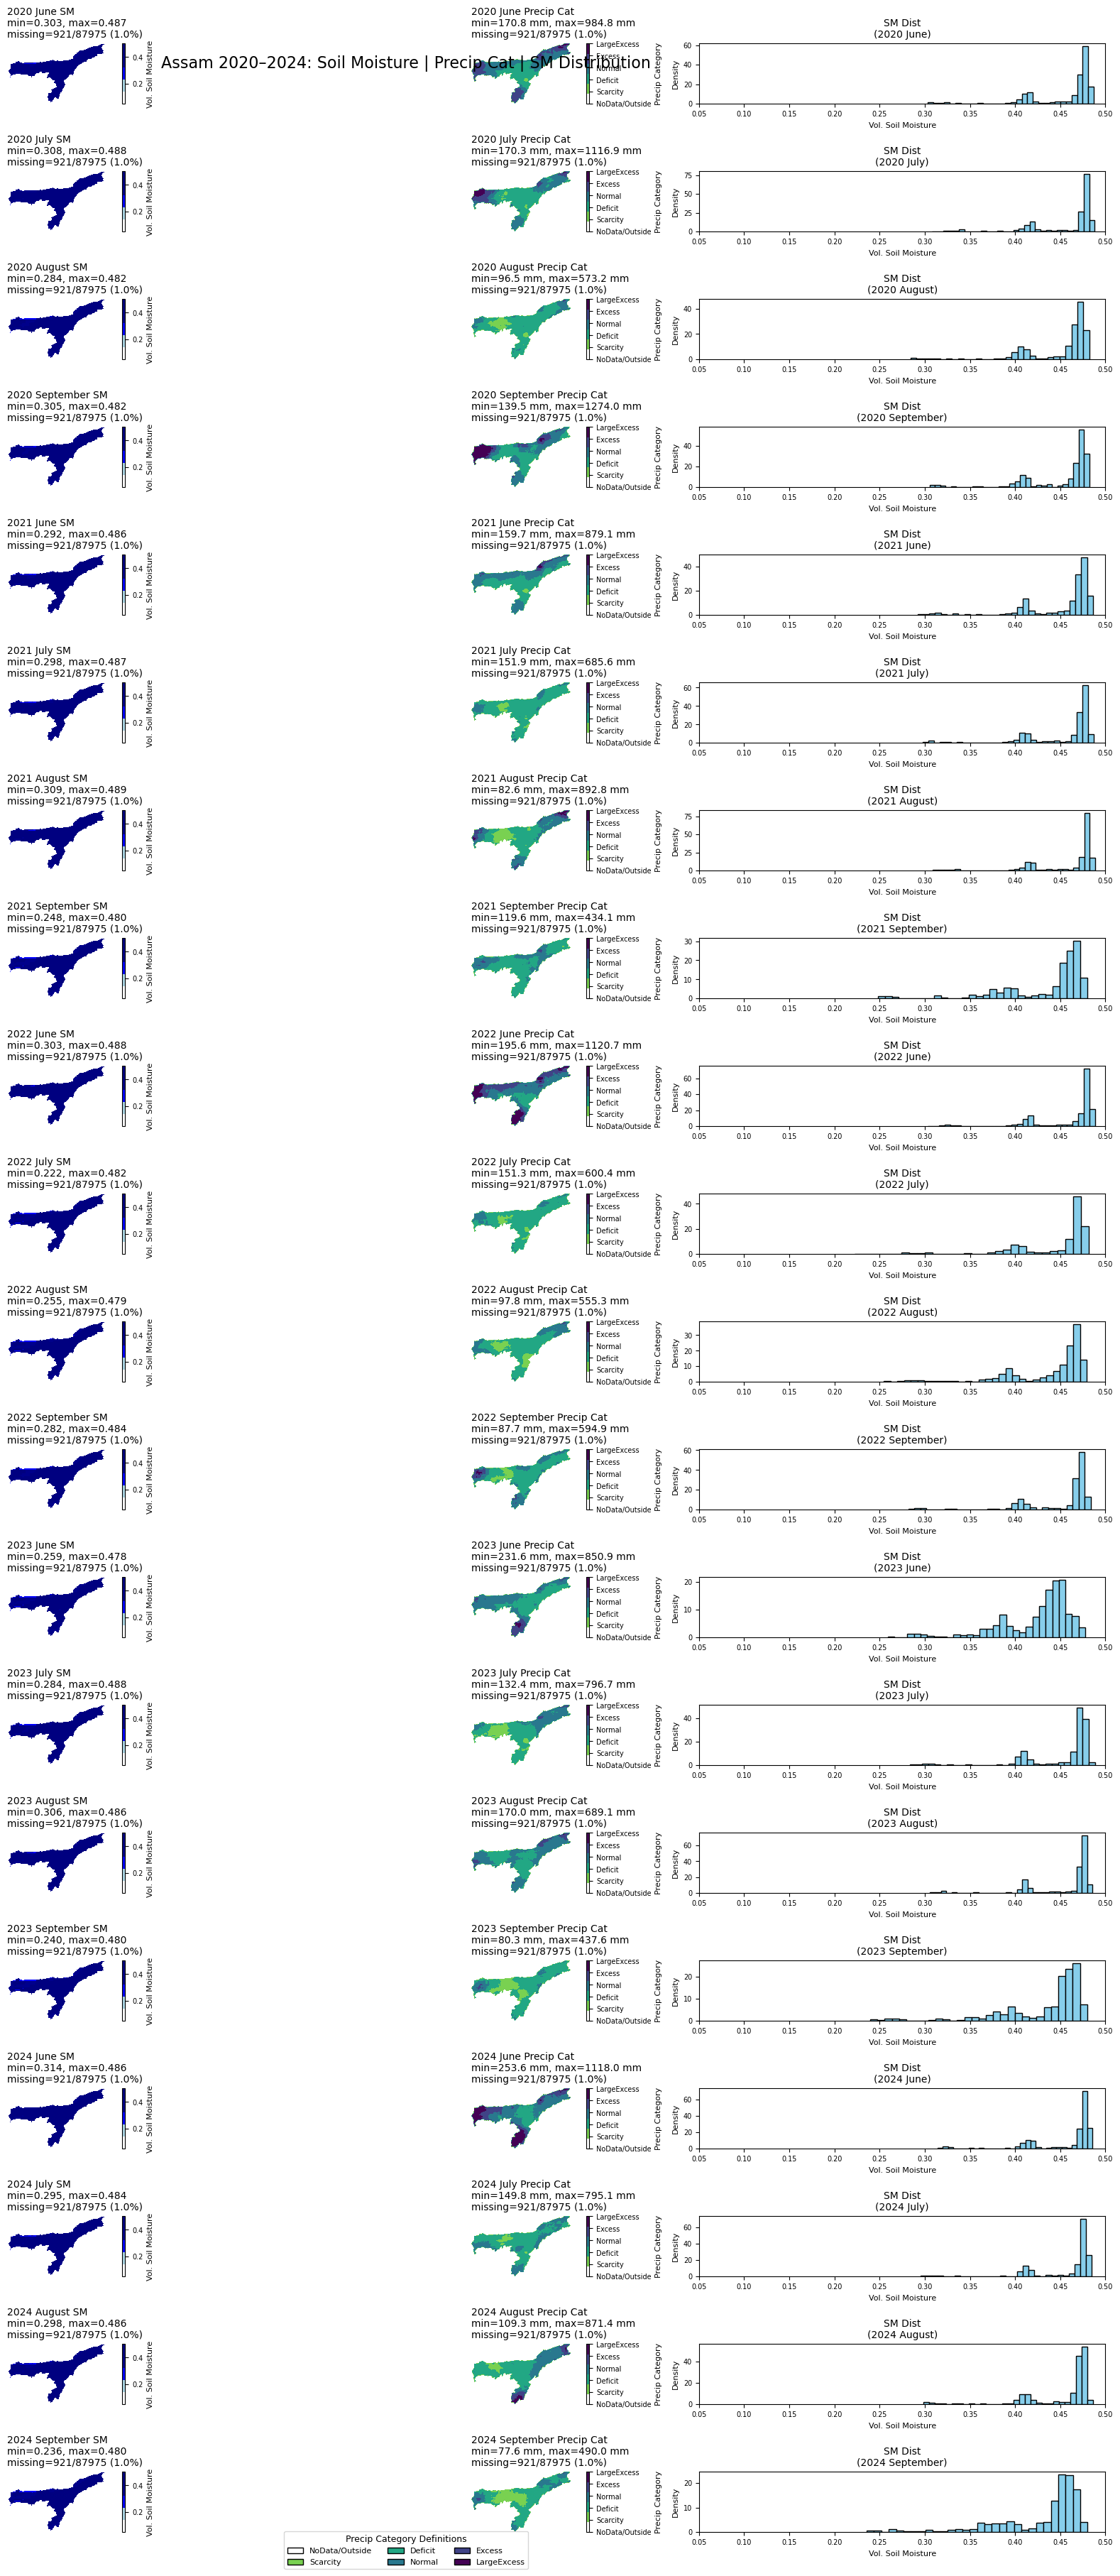

In [16]:
import os
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Assam)
# -----------------------------------------------------------------------------
sm_tiff_path        = "Assam_X_Soil_Moisture.tif"
precip_raw_tiff     = "Assam_Y_Precipitation_CHIRPS.tif"
precip_cat_tiff     = "Assam_Y_Precipitation_GT_geotif.tif"
india_shapefile     = "SateMask/gadm41_IND_1.shp"

for path in (sm_tiff_path, precip_raw_tiff, precip_cat_tiff, india_shapefile):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Cannot find {path!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE 20‐BAND SOIL MOISTURE TIFF
# -----------------------------------------------------------------------------
with rasterio.open(sm_tiff_path) as src_sm:
    sm_bands      = src_sm.read().astype(np.float32)  # (20, H, W)
    sm_transform  = src_sm.transform
    sm_crs        = src_sm.crs
    height, width = src_sm.height, src_sm.width
    bounds        = src_sm.bounds

if sm_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {sm_tiff_path}, but found {sm_bands.shape[0]}")

# load India states & build Assam mask
gdf = gpd.read_file(india_shapefile)
gdf_assam = gdf[gdf["NAME_1"].str.lower() == "assam"].copy()
if gdf_assam.empty:
    raise ValueError("No feature named 'Assam' found in shapefile.")
if gdf_assam.crs != sm_crs:
    gdf_assam = gdf_assam.to_crs(sm_crs)

assam_geom = [gdf_assam.geometry.union_all()]
assam_mask = geometry_mask(
    assam_geom,
    transform=sm_transform,
    invert=True,
    out_shape=(height, width)
)

# total pixels inside Assam
total_inside = np.count_nonzero(assam_mask)
print(f"Total pixels inside Assam: {total_inside}")

# mask soil moisture outside Assam
for i in range(sm_bands.shape[0]):
    band = sm_bands[i]
    band[~assam_mask] = np.nan
    sm_bands[i] = band

# -----------------------------------------------------------------------------
# 3) READ & MASK THE 25‐BAND RAW PRECIPITATION TIFF (in mm)
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff) as src_pr:
    pr_raw_full = src_pr.read().astype(np.float32)  # (25, H, W)

if pr_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_raw_tiff}, but found {pr_raw_full.shape[0]}")

for i in range(pr_raw_full.shape[0]):
    arr = pr_raw_full[i]
    arr[~assam_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 4) READ & MASK THE 25‐BAND PRECIPITATION CATEGORY TIFF
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff) as src_pc:
    pr_cat_full = src_pc.read().astype(np.int8)  # (25, H, W)

if pr_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_cat_tiff}, but found {pr_cat_full.shape[0]}")

for i in range(pr_cat_full.shape[0]):
    arr = pr_cat_full[i]
    arr[~assam_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 5) EXTRACT 20 MONTHLY PRECIPITATION BANDS
#    (drop totals at indices 4, 9, 14, 19, 24)
# -----------------------------------------------------------------------------
monthly_idx = []
for y in range(5):
    base = y * 5
    monthly_idx.extend([base + m for m in range(4)])

pr_raw = pr_raw_full[monthly_idx]  # (20, H, W)
pr_cat = pr_cat_full[monthly_idx]  # (20, H, W)

# -----------------------------------------------------------------------------
# 6) DEFINE YEARS & MONTHS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
month_names = ["June", "July", "August", "September"]
n_years, n_months = len(years), len(month_names)
n_total = n_years * n_months  # 20

# -----------------------------------------------------------------------------
# 7) PREPARE COLORMAPS & STATS
# -----------------------------------------------------------------------------
# Soil Moisture colormap
sm_cmap = ListedColormap(["white","lightblue","blue","darkblue","navy"])
sm_vmin, sm_vmax = 0.05, 0.5

# Precip category colormap
cluster_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
pr_cmap = ListedColormap(cluster_colors)
pr_labels = {
    0: "NoData/Outside",1: "Scarcity",2: "Deficit",
    3: "Normal",4: "Excess",5: "LargeExcess"
}
pr_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=pr_labels[i])
    for i in range(6)
]

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(n_total, 3, figsize=(20, n_total*1.8), constrained_layout=True)
fig.suptitle("Assam 2020–2024: Soil Moisture | Precip Cat | SM Distribution", fontsize=16, y=0.98)
if n_total == 1:
    axes = axes[np.newaxis, :]

# -----------------------------------------------------------------------------
# 9) LOOP, COMPUTE MISSING, PLOT
# -----------------------------------------------------------------------------
for i in range(n_total):
    yr_idx, mo_idx = divmod(i, n_months)
    year, month = years[yr_idx], month_names[mo_idx]

    # Soil Moisture stats + missing
    sm_layer = sm_bands[i]
    valid_sm = sm_layer[~np.isnan(sm_layer)]
    sm_min = float(np.nanmin(valid_sm)) if valid_sm.size else None
    sm_max = float(np.nanmax(valid_sm)) if valid_sm.size else None
    miss_sm = np.count_nonzero(np.isnan(sm_layer[assam_mask]))
    pct_sm  = miss_sm / total_inside * 100
    print(f"{year} {month} → SM missing: {miss_sm}/{total_inside} ({pct_sm:.2f}%)")

    # Raw Precip stats + missing
    pr_layer = pr_raw[i]
    valid_pr = pr_layer[~np.isnan(pr_layer)]
    pr_min = float(np.nanmin(valid_pr)) if valid_pr.size else None
    pr_max = float(np.nanmax(valid_pr)) if valid_pr.size else None
    miss_pr = np.count_nonzero(np.isnan(pr_layer[assam_mask]))
    pct_pr  = miss_pr / total_inside * 100
    print(f"{year} {month} → Precip missing: {miss_pr}/{total_inside} ({pct_pr:.2f}%)")

    # Precip category shift -1..4 → 0..5
    raw_cat = pr_cat[i]
    cat_plot = np.zeros_like(raw_cat, dtype=np.int8)
    valid_mask = (raw_cat != -1)
    cat_plot[valid_mask] = raw_cat[valid_mask] + 1

    # — Column 0: Soil Moisture Map —
    ax0 = axes[i, 0]
    im0 = ax0.imshow(
        sm_layer, cmap=sm_cmap, vmin=sm_vmin, vmax=sm_vmax,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
        origin="upper"
    )
    title0 = f"{year} {month} SM\n"
    if sm_min is not None:
        title0 += f"min={sm_min:.3f}, max={sm_max:.3f}\n"
    title0 += f"missing={miss_sm}/{total_inside} ({pct_sm:.1f}%)"
    ax0.set_title(title0, fontsize=10, loc="left")
    ax0.axis("off")
    cb0 = fig.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)
    cb0.set_label("Vol. Soil Moisture", fontsize=8)
    cb0.ax.tick_params(labelsize=7)

    # — Column 1: Precip Category Map —
    ax1 = axes[i, 1]
    im1 = ax1.imshow(
        cat_plot, cmap=pr_cmap, vmin=0, vmax=5,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
        origin="upper"
    )
    title1 = f"{year} {month} Precip Cat\n"
    if pr_min is not None:
        title1 += f"min={pr_min:.1f} mm, max={pr_max:.1f} mm\n"
    title1 += f"missing={miss_pr}/{total_inside} ({pct_pr:.1f}%)"
    ax1.set_title(title1, fontsize=10, loc="left")
    ax1.axis("off")
    cb1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cb1.set_ticks([0,1,2,3,4,5])
    cb1.set_ticklabels([pr_labels[j] for j in range(6)], fontsize=7)
    cb1.ax.tick_params(labelsize=7)
    cb1.set_label("Precip Category", fontsize=8)

    # — Column 2: SM Distribution —
    ax2 = axes[i, 2]
    if valid_sm.size > 0:
        ax2.hist(valid_sm.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(sm_vmin, sm_vmax)
    else:
        ax2.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=8, color="gray")
    ax2.set_title(f"SM Dist\n({year} {month})", fontsize=10)
    ax2.set_xlabel("Vol. Soil Moisture", fontsize=8)
    ax2.set_ylabel("Density", fontsize=8)
    ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 10) Legend for Precipitation Categories
# -----------------------------------------------------------------------------
fig.legend(
    handles=pr_handles,
    loc="lower center",
    ncol=3,
    frameon=True,
    title="Precip Category Definitions",
    bbox_to_anchor=(0.5, -0.005),
    fontsize=8,
    title_fontsize=9
)

plt.show()


In [ ]:
##Assam_elevation_missing_values

In [18]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Assam)
# -----------------------------------------------------------------------------
elev_tiff_path        = "Assam_X_Elevation.tif"
precip_raw_tiff_path  = "Assam_Y_Precipitation_CHIRPS.tif"
precip_cat_tiff_path  = "Assam_Y_Precipitation_GT_geotif.tif"
india_shapefile       = "SateMask/gadm41_IND_1.shp"

for p in (elev_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK ELEVATION
# -----------------------------------------------------------------------------
with rasterio.open(elev_tiff_path) as src:
    elev_bands     = src.read().astype(np.float32)  # (20, H, W)
    elev_transform = src.transform
    elev_crs       = src.crs
    height, width  = src.height, src.width
    bounds         = src.bounds

if elev_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {elev_tiff_path}, found {elev_bands.shape[0]}")

# load and mask Assam
gdf = gpd.read_file(india_shapefile)
gdf_assam = gdf[gdf["NAME_1"].str.lower() == "assam"]
if gdf_assam.empty:
    raise ValueError("No 'Assam' feature in shapefile.")
if gdf_assam.crs != elev_crs:
    gdf_assam = gdf_assam.to_crs(elev_crs)
assam_geom = [gdf_assam.geometry.union_all()]
assam_mask = geometry_mask(
    assam_geom,
    transform=elev_transform,
    invert=True,
    out_shape=(height, width)
)
total_inside = np.count_nonzero(assam_mask)
print(f"Total pixels inside Assam: {total_inside}")

for i in range(elev_bands.shape[0]):
    band = elev_bands[i]
    band[~assam_mask] = np.nan
    elev_bands[i] = band

# -----------------------------------------------------------------------------
# 3) READ & MASK RAW PRECIPITATION
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src:
    pr_raw_full = src.read().astype(np.float32)  # (25, H, W)

if pr_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in raw precip, found {pr_raw_full.shape[0]}")

for i in range(pr_raw_full.shape[0]):
    arr = pr_raw_full[i]
    arr[~assam_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 4) READ & MASK PRECIP CATEGORY
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src:
    pr_cat_full = src.read().astype(np.int8)  # (25, H, W)

if pr_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in precip cat, found {pr_cat_full.shape[0]}")

for i in range(pr_cat_full.shape[0]):
    arr = pr_cat_full[i]
    arr[~assam_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 5) EXTRACT 20 MONTHLY PRECIP (drop each year's Total at idx 4,9,14,19,24)
# -----------------------------------------------------------------------------
monthly_indices = []
for y in range(5):
    base = y * 5
    monthly_indices.extend([base + m for m in range(4)])
pr_raw_bands = pr_raw_full[monthly_indices]  # (20,H,W)
pr_cat_bands = pr_cat_full[monthly_indices]  # (20,H,W)

# -----------------------------------------------------------------------------
# 6) SETUP YEARS & MONTHS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
month_names = ["June", "July", "August", "September"]
n_years, n_months = len(years), len(month_names)
n_total = n_years * n_months  # 20

# -----------------------------------------------------------------------------
# 7) COLORMAPS & GLOBAL STATS
# -----------------------------------------------------------------------------
# elevation
all_elev = elev_bands.flatten()
all_elev = all_elev[~np.isnan(all_elev)]
elev_vmin = float(np.min(all_elev)) if all_elev.size else 0
elev_vmax = float(np.max(all_elev)) if all_elev.size else 0
elev_cmap = plt.get_cmap("terrain")

# precip category
cluster_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
cluster_cmap    = ListedColormap(cluster_colors)
cluster_labels  = {
    0:"NoData/Outside",1:"Scarcity",2:"Deficit",
    3:"Normal",4:"Excess",5:"LargeExcess"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(6)
]

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(n_total, 3, figsize=(20, n_total*2.0), constrained_layout=True)
fig.suptitle("Assam 2020–2024: Elevation | Precip Cat | Elevation Dist", fontsize=16, y=0.97)
if n_total == 1:
    axes = axes[np.newaxis, :]

# -----------------------------------------------------------------------------
# 9) LOOP & PLOT WITH MISSING STATS
# -----------------------------------------------------------------------------
for i in range(n_total):
    y_idx, m_idx = divmod(i, n_months)
    year, mon    = years[y_idx], month_names[m_idx]

    # elevation stats + missing
    elev_layer = elev_bands[i]
    valid_el   = elev_layer[~np.isnan(elev_layer)]
    el_min = float(np.min(valid_el)) if valid_el.size else np.nan
    el_max = float(np.max(valid_el)) if valid_el.size else np.nan
    miss_el = np.count_nonzero(np.isnan(elev_layer[assam_mask]))
    pct_el  = miss_el / total_inside * 100
    print(f"{year} {mon} → Elev missing: {miss_el}/{total_inside} ({pct_el:.2f}%)")

    # precip raw stats + missing
    pr_layer = pr_raw_bands[i]
    valid_pr = pr_layer[~np.isnan(pr_layer)]
    pr_min = float(np.min(valid_pr)) if valid_pr.size else np.nan
    pr_max = float(np.max(valid_pr)) if valid_pr.size else np.nan
    miss_pr = np.count_nonzero(np.isnan(pr_layer[assam_mask]))
    pct_pr  = miss_pr / total_inside * 100
    print(f"{year} {mon} → Precip missing: {miss_pr}/{total_inside} ({pct_pr:.2f}%)")

    # precip category shift
    raw_cat = pr_cat_bands[i]
    cat_plot = np.zeros_like(raw_cat, dtype=np.int8)
    mask_ok = (raw_cat != -1)
    cat_plot[mask_ok] = raw_cat[mask_ok] + 1

    # --- Column 0: Elevation Map ---
    ax0 = axes[i,0]
    im0 = ax0.imshow(
        elev_layer, cmap=elev_cmap, vmin=elev_vmin, vmax=elev_vmax,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
        origin="upper"
    )
    t0 = (
        f"{year} {mon} Elev\n"
        f"min={el_min:.0f} m, max={el_max:.0f} m\n"
        f"missing={miss_el}/{total_inside} ({pct_el:.1f}%)"
    )
    ax0.set_title(t0, loc="left", fontsize=9)
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, fraction=0.04, pad=0.02)
    c0.set_label("Elevation (m)", fontsize=8)
    c0.ax.tick_params(labelsize=7)

    # --- Column 1: Precip Category Map ---
    ax1 = axes[i,1]
    im1 = ax1.imshow(
        cat_plot, cmap=cluster_cmap, vmin=0, vmax=5,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
        origin="upper"
    )
    t1 = (
        f"{year} {mon} Precip Cat\n"
        f"min={pr_min:.1f} mm, max={pr_max:.1f} mm\n"
        f"missing={miss_pr}/{total_inside} ({pct_pr:.1f}%)"
    )
    ax1.set_title(t1, loc="left", fontsize=9)
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, fraction=0.04, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5])
    c1.set_ticklabels([cluster_labels[j] for j in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=7)
    c1.set_label("Precip Cat", fontsize=8)

    # --- Column 2: Elevation Distribution ---
    ax2 = axes[i,2]
    if valid_el.size:
        ax2.hist(valid_el.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(elev_vmin, elev_vmax)
    else:
        ax2.text(0.5,0.5,"No Data", ha="center", va="center", fontsize=8, color="gray")
    ax2.set_title(f"Elev Dist\n({year} {mon})", fontsize=9)
    ax2.set_xlabel("Elevation (m)", fontsize=8)
    ax2.set_ylabel("Density", fontsize=8)
    ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 10) BOTTOM LEGEND
# -----------------------------------------------------------------------------
fig.legend(
    handles=cluster_handles,
    loc="lower center",
    ncol=3,
    frameon=True,
    title="Precip Category",
    fontsize=8,
    title_fontsize=9,
    bbox_to_anchor=(0.5,-0.005)
)

plt.show()


FileNotFoundError: Cannot find 'Assam_X_Elevation.tif' in /home/aparajita/Desktop/Weather Analytics/Weather_Analytics/GridData/Assam